<a href="https://colab.research.google.com/github/sepehrX12/Intrinsic-Alignment-Project/blob/main/Copy_of_shear_2pcf_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#if you have not install CLASS on colab yet, do this once:
%%shell
git clone https://github.com/lesgourg/class_public.git class
cd class
make;

Cloning into 'class'...
remote: Enumerating objects: 30474, done.
remote: Counting objects: 100% (6680/6680), done.
remote: Compressing objects: 100% (457/457), done.
remote: Total 30474 (delta 6534), reused 6223 (delta 6223), pack-reused 23794
Receiving objects: 100% (30474/30474), 738.61 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (21221/21221), done.
if ! [ -e /content/class/build ]; then mkdir /content/class/build ; mkdir /content/class/build/lib; fi;
touch build/.base
cd /content/class/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -c ../tools/growTable.c -o growTable.o
cd /content/class/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -c ../tools/dei_rkck.c -o dei_rkck.o
cd /content/class/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class"'

In [ ]:
%%shell
pip install ./class/python


Processing ./class/python
  Preparing metadata (setup.py) ... done
  Created wheel for classy: filename=classy-3.2.3-cp310-cp310-linux_x86_64.whl size=4879337 sha256=03e4687648d88da79fe149a16ae8a14ec96a2674572e92e112face5d4b8d6de2
  Stored in directory: /tmp/pip-ephem-wheel-cache-tiltw1tm/wheels/7a/17/af/3f3e08aa49067558ebdb4472cb4e12d8f1b412ed5a0b99d89c
Successfully built classy
  Attempting uninstall: classy
    Found existing installation: classy 3.2.3
    Uninstalling classy-3.2.3:
      Successfully uninstalled classy-3.2.3


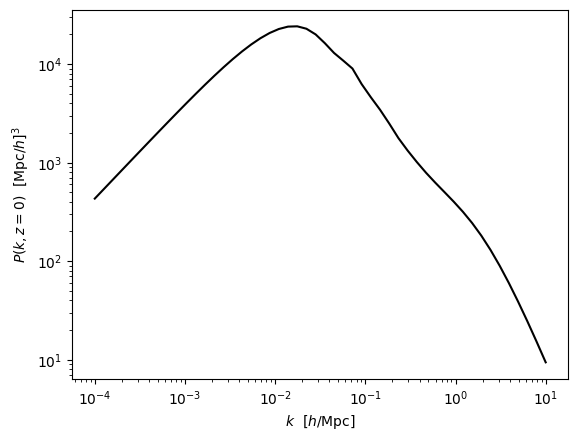

In [ ]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

#set parameters to configure CLASS computations
zmax = 2
params = {
    'output': 'mPk', #which quantities we want CLASS to compute
    'H0':70, #cosmology paramater
    'z_max_pk' : str(zmax),
    'non linear' : 'halofit',#option for computing non-linear power spectum
    'P_k_max_1/Mpc':100.0,
    'sigma8': 0.8, #cosmology parameter
    'n_s': 0.9624, #cosmology parameter
    'Omega_b': 0.048, #cosmology parameter
    'Omega_cdm': 0.25 #cosmology parameter
}
#initialize Class instance and set parameters
cosmo = Class()
cosmo.set(params)
cosmo.compute()
# get P(k) at redshift z=0
Nk = 50
Pnl = np.zeros(Nk)
h = cosmo.h() # get reduced Hubble for conversions to 1/Mpc
kvec = np.exp(np.linspace(np.log(1.e-4),np.log(10.),Nk))
for k in range(Nk):
    Pnl[k] = cosmo.pk(kvec[k]*h,0.0)*h**3 #using method .pk(k,z), convert to Mpc/h units
plt.loglog(kvec,Pnl, 'k-')
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$');
plt.ylabel(r'$P(k,z=0) \,\,\,\, [\mathrm{Mpc}/h]^3$');
plt.show()

#now extend this to (k,z) or (k,a) and set up an efficient interpolator

# Cosmic Shear 2PCF
In this notebook, you will calculate (simplified) predictions for the cosmic shear two-point correlation functions $\xi^{ij}_\pm$.
Let's start by visualizing the DES-Y3 measurements of $\xi^{ij}_\pm$ for the second and fourth tomographic redshift bins:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#read in DES measurement
datavfile = 'https://github.com/CosmoLike/des_y3_shear/raw/main/datav/Y3_shear_final.txt'
d = np.genfromtxt(datavfile)[:,1]
#read in DES data covariance, so that we can plot error bars
covfile = 'https://github.com/CosmoLike/des_y3_shear/raw/main/cov_y3/cov_shear_final.txt'
ndata = d.shape[0]
cov =np.zeros((ndata,ndata))
data = np.genfromtxt(covfile)
for i in range(0,data.shape[0]):
	cov[int(data[i,0]),int(data[i,1])] = data[i,2]
	cov[int(data[i,1]),int(data[i,0])] = data[i,2]
#calculate error bars
sigma = np.sqrt(np.diag(cov))

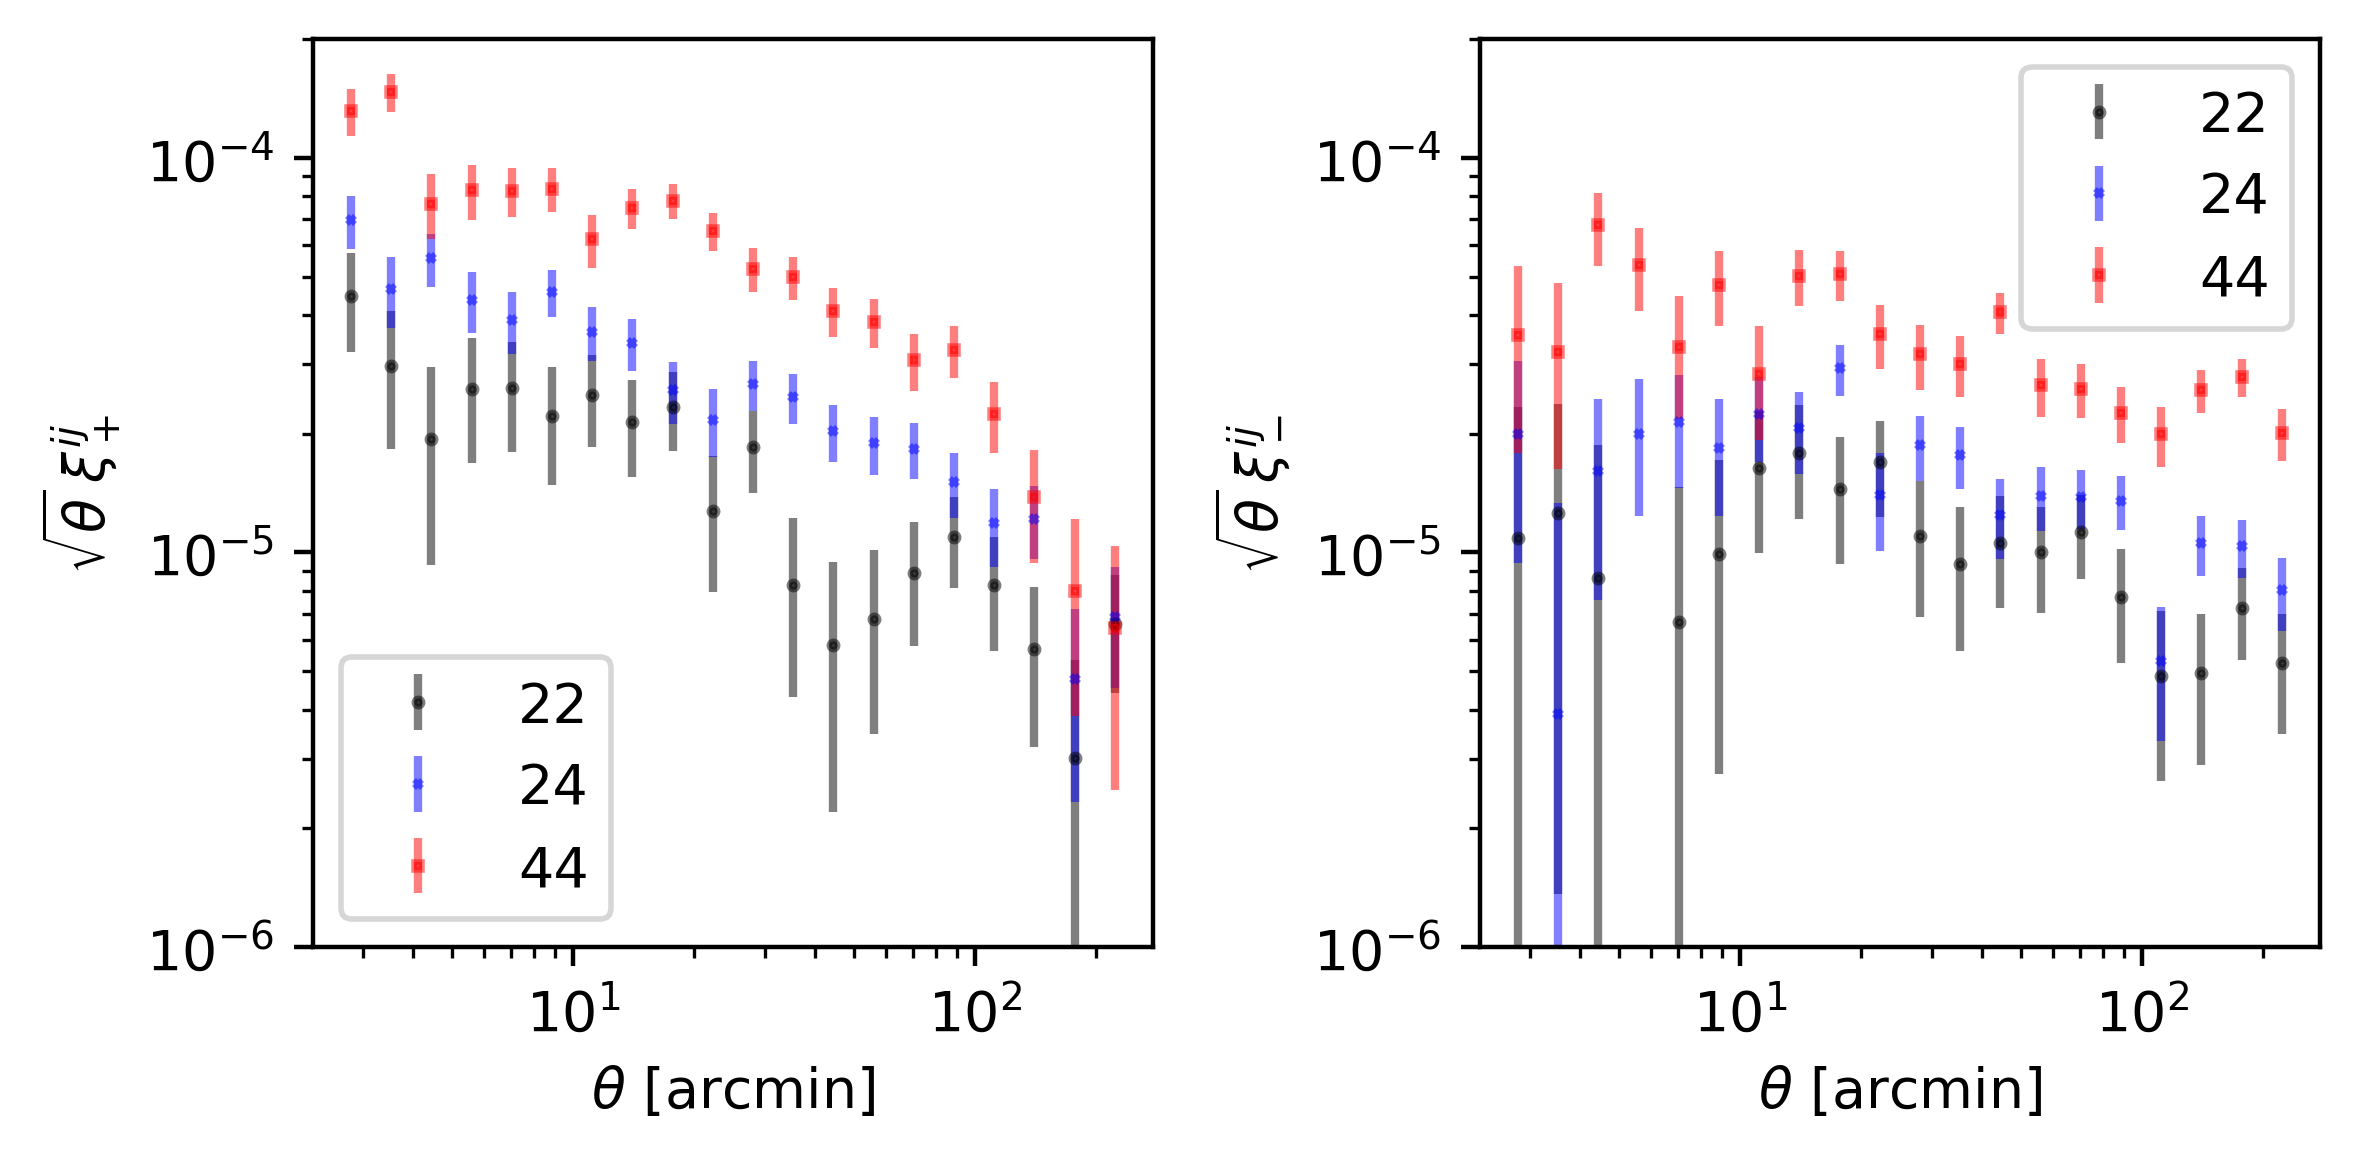

In [ ]:
#parameters describing the angular bining
N_theta_bins = 20
theta_min_arcmin = 2.5
theta_max_arcmin = 250.0
theta_edges= np.logspace(np.log10(2.5),np.log10(250),num=21)
#represent bin at geometric mean of bin edges
theta =np.sqrt(theta_edges[:-1]*theta_edges[1:])
plt.figure(figsize=(6,3), dpi=400)
fs = 18
plt.subplot(1,2,1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\,\xi_+^{ij}$')
plt.ylim(1.e-6,2.e-4)
##xi_+^{22}
ind = np.arange(80,100)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='o', color='k',linestyle = '',markersize = 1.5,alpha = 0.5,label = "22")
#xi_+^{24}
ind = np.arange(120,140)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='x', color='b',linestyle = '',markersize = 1.5,alpha = 0.5, label = "24")
#xi_+^{44}
ind = np.arange(180,200)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='s', color='r',linestyle = '',markersize = 1.5,alpha = 0.5, label = "44")
plt.legend()

plt.subplot(1,2,2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\,\xi_-^{ij}$')
plt.ylim(1.e-6,2.e-4)
##xi_-^{22}
ind = np.arange(280,300)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='o', color='k',linestyle = '',markersize = 1.5,alpha = 0.5,label = "22")
#xi_-^{24}
ind = np.arange(320,340)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='x', color='b',linestyle = '',markersize = 1.5,alpha = 0.5, label = "24")
#xi_-^{44}
ind = np.arange(380,400)
plt.errorbar(theta,d[ind]*np.sqrt(theta),yerr=sigma[ind]*np.sqrt(theta), marker='s', color='r',linestyle = '',markersize = 1.5,alpha = 0.5, label = "44")
plt.legend()
plt.tight_layout()

## From cosmology parameters to cosmic shear statistics
The theoretical predictions for the tomographic cosmic shear two-point correlation functions can be computed as (c.f. [DES-Y3 methods paper](https://arxiv.org/pdf/2105.13548.pdf))
$$
\xi_{\pm}^{ij}(\theta) = \sum_\ell\frac{2\ell+1}{2\pi\ell^2(\ell+1)^2}[G_{\ell,2}^+(\cos\theta)\pm G_{\ell,2}^-(\cos\theta)]\times \left[ C^{ij}_{EE}(\ell)\pm C^{ij}_{BB}(\ell)\right]\,,
$$
with $C^{ij}_{EE/BB}(\ell)$ the angular weak lensing power spectra, and $G_{\ell,m}^{+/-}$ given by Eq.~(4.19) of [Stebbins et al. 1996](https://arxiv.org/pdf/astro-ph/9609149.pdf).

**Today, we will neglect any contribution from intrinsic alignments**, so that the $E$-mode power spectra is given by the lensing covergence power spectrum $C^{ij}_{EE}(\ell) =C^{ij}_{\kappa\kappa}(\ell)$ and no $B$-modes, $C^{ij}_{BB}(\ell) =0$:

$$
\xi_{\pm}^{ij}(\theta) \approx \sum_\ell\frac{2\ell+1}{2\pi\ell^2(\ell+1)^2}[G_{\ell,2}^+(\cos\theta)\pm G_{\ell,2}^-(\cos\theta)]
C^{ij}_{\kappa\kappa}(\ell)\,,\label{1}
$$

with
$$
C_{\kappa\kappa}^{ij}(\ell) = \int d\chi \frac{W_\kappa^i(\chi)W_\kappa^j(\chi)}{\chi^2}P_{\rm{m}}\left(k = \frac{\ell+0.5}{\chi},z(\chi)\right)\,,
$$
with $W_\kappa^i(\chi)$ the lens efficiency of tomographic bin $i$.



### Task 0
While the above expressions look simple, and you may find evaluating the model prediction at one $\theta$ value and for one particular tomography bin easy, computational efficiency is essential for writing a cosmology likelihood: at each step of an MCMC, we have to evaluate the model for over 200 data points (different angular scales and different tomography bin combinations), and then repeat this for ten thousands of samples!


Sketch out how to structure this computation efficiently, and then discuss your design with your neighbor.


### Task 1
To simplify the computation of the angular convergence power spectrum, rewrite the Limber integral for $C_{\kappa\kappa}$ as integral over scale factor or redshift.

$$
C_{\kappa\kappa}^{ij}(\ell) = \int cdz \frac{W_\kappa^i(z)W_\kappa^j(z)}{H(z)\chi(z)^2}P_{\rm{m}}\left(k = \frac{\ell+0.5}{\chi(z)},z\right)
$$

### Task 2
Calculate the lens efficiency
$$
W_{\kappa}^i (\chi)= \frac{3\Omega_{\rm m} H_0^2}{2c^2}\frac{\chi}{a(\chi)}\int_\chi^{\infty} d\chi' n^i(\chi')
 \frac{\chi'-\chi}{\chi'}
$$
for the DES-Y3 source redshift distribution given in `zdistris/nz_source_Y3_unblinded_final.txt`, which has the format
```
    z n^1(z) n^2(z) n^3(z) n^4(z)
```

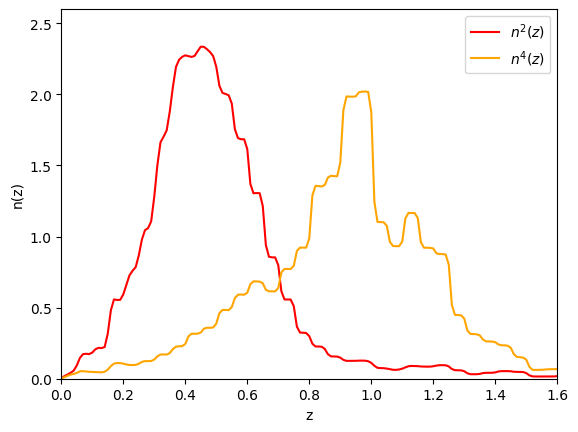

In [ ]:
zdata = np.genfromtxt('https://github.com/CosmoLike/des_y3_shear/raw/main/zdistris/nz_source_Y3_unblinded_final.txt')
z = zdata[:,0]
n = zdata[:,1:]
dz = z[1]-z[0]
plt.xlim(0,1.6)
plt.ylim(0,2.6)
plt.plot(z,n[:,1]/dz,c='r',label=r'$n^2(z)$')
plt.plot(z,n[:,3]/dz,c='orange',label=r'$n^4(z)$')
plt.legend()
plt.xlabel('z');
plt.ylabel('n(z)');

You can check your result against Fig. 3 in [Secco et al. 2022](https://arxiv.org/pdf/2105.13544.pdf])

In [ ]:
#you can get the comoving distance from CLASS like this:
#cosmo.angular_distance(z)*(1+z) #[L]

0.00980155397756059 0.009630810138055853


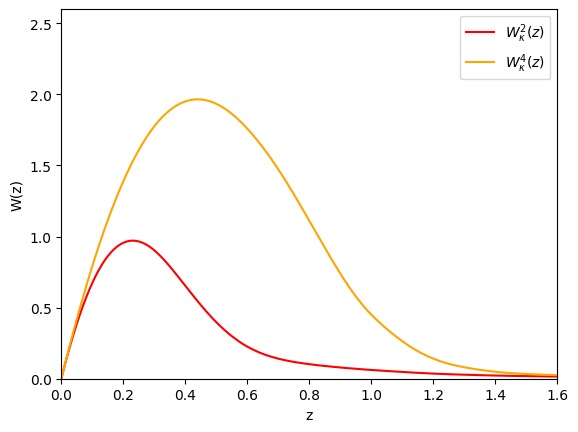

In [ ]:
n_2 = 0
n_4 = 0
for i in range(len(z)):
  n_2 += n[i,1]*dz
  n_4 += n[i,3]*dz
print(n_2, n_4)

def efficiency(z_ind, z_data, n_data): # efficiency function
  z = z_data[z_ind]
  chi = cosmo.angular_distance(z)*(1+z)
  const = 3 * cosmo.Hubble(0)**2 * cosmo.Om_m(0) / (2)
  dz = z_data[1]-z_data[0]
  integral = 0
  for i in range(z_ind , len(z_data)):
    integral += dz * n_data[i] * (1 - (chi / (cosmo.angular_distance(z_data[i])*(1+z_data[i])))) / cosmo.Hubble(z_data[i])
  return (integral * const * chi * (1+z) )

eff_2 = [0]
eff_4 = [0]
chi = [0]
for i in range(1, len(z)):  # efficiency values
  eff_2.append(efficiency(i, z, n[:,1]) * 3.166e-2)
  eff_4.append(efficiency(i, z, n[:,3]) * 4.082e-2)
  chi.append(cosmo.angular_distance(z[i])*(1+z[i]))

plt.xlim(0,1.6)
plt.ylim(0,2.6)
plt.plot(z,eff_2/n_2*800,c='r',label=r'$W_\kappa^2(z)$')
plt.plot(z,eff_4/n_4*800,c='orange',label=r'$W_\kappa^4(z)$')
plt.legend()
plt.xlabel('z');
plt.ylabel('W(z)');


### Task 3
Build a 2D interpolator of the matter power spectrum (from `CLASS`) as a function of Fourier mode `k` and your Limber integration variable (scale factor or redshift).

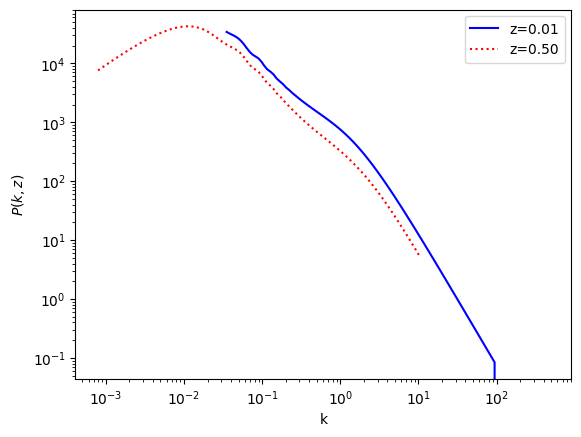

In [ ]:
Nell = 100
Nz = z.shape[0]
ell = np.exp(np.linspace(np.log(1.),np.log(2.e+4),Nell))
P2D = np.zeros((Nell,Nz))
for i in range(1,Nz):
  zi = z[i]
  k = (ell+0.5)/chi[i]
  for j in range(Nell):
    if (k[j]<100.):
      P2D[j,i] =cosmo.pk(k[j],zi)#in Mpc units

plt.loglog((ell+0.5)/chi[1],P2D[:,1], 'b-',label='z=%.2f'%(z[1]))
plt.loglog((ell+0.5)/chi[50],P2D[:,50], 'r:',label='z=%.2f'%(z[50]))
plt.legend();
plt.xlabel('k');
plt.ylabel('$P(k,z)$');

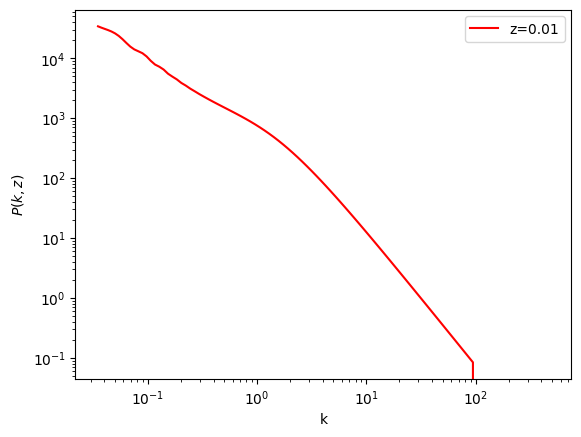

In [ ]:
from scipy.interpolate import RegularGridInterpolator
from scipy.special import lpmv

Pk_interpolator = RegularGridInterpolator((ell, z), P2D, method='linear') # 2D interpolator
def Pk_int(k,z):  # relating k and ell
  l = (k * cosmo.comoving_distance(z) - 0.5)
  if (l < 1):
    l = 1
  if (0 < l < 1.e+4 and k < 100):
    return Pk_interpolator((l,z))
  return 0

z_test = z[1]
P_plot = [Pk_int(ki,z_test) for ki in (ell+0.5)/(cosmo.comoving_distance(z_test))]
plt.loglog((ell+0.5)/cosmo.comoving_distance(z_test),P_plot, 'r-',label='z=%.2f'%(z_test))
plt.legend();
plt.xlabel('k');
plt.ylabel('$P(k,z)$');

### Task 4
Calculate the angular convergence power spectrum $C^{ij}_{\kappa\kappa}(\ell)$.

In [ ]:
# chi and H(z) datas for redshifts
chi_data = [cosmo.angular_distance(z[i]) * (1+z[i]) for i in range(len(z))]
hubble_data = [cosmo.Hubble(z[i]) for i in range(len(z))]

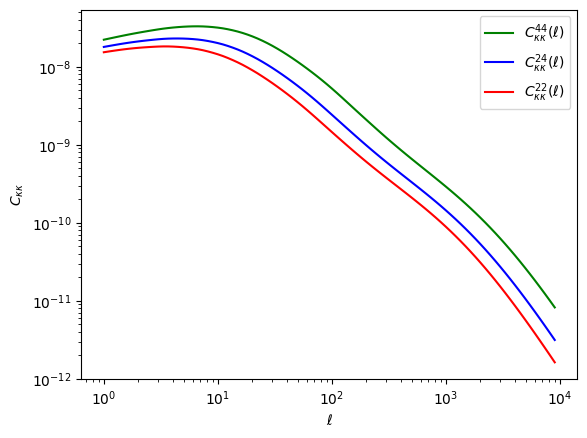

In [ ]:
def conv_spectrum(l, z_data, effi_2, effi_4, chi_data, hubble_data): # C_kk function
  dz = z_data[1]-z_data[0]
  integral = 0
  for i in range(0 , len(z_data)-1):
    k_val = 2*(l + 0.5) / (chi_data[i]+chi_data[i+1])
    if (k_val < 100):
      integral += dz * (effi_2[i] + effi_2[i+1])/2 * (effi_4[i]+effi_4[i+1])/2 /(((chi_data[i]+chi_data[i+1])/2) ** 2) /((hubble_data[i]+hubble_data[i+1])/2) * Pk_int(k_val, (z_data[i]+z_data[i+1])/2)
  return (integral)

c_24 = []
for l in ell:
  c_24.append(conv_spectrum(l, z, eff_2, eff_4, chi_data, hubble_data))
c_22 = []
for i in range(Nell):
  c_22.append(conv_spectrum(ell[i], z, eff_2, eff_2, chi_data, hubble_data))
c_44 = []
for i in range(Nell):
  c_44.append(conv_spectrum(ell[i], z, eff_4, eff_4, chi_data, hubble_data))

plt.loglog(ell[:-8],c_44[:-8], 'g-',label='$C_{\kappa\kappa}^{44}(\ell)$')
plt.loglog(ell[:-8],c_24[:-8], 'b-',label='$C_{\kappa\kappa}^{24}(\ell)$')
plt.loglog(ell[:-8],c_22[:-8], 'r-',label='$C_{\kappa\kappa}^{22}(\ell)$')
plt.legend();
plt.xlabel('$\ell$');
plt.ylabel('$C_{\kappa\kappa}$');

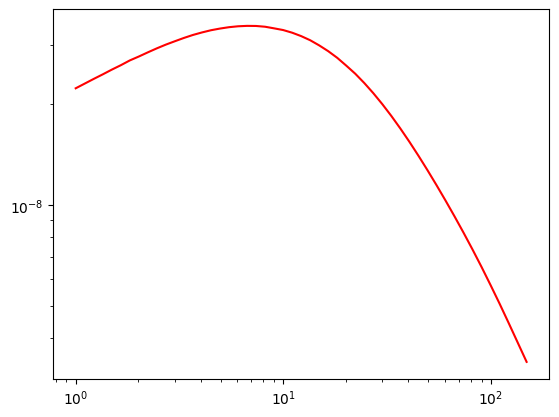

In [ ]:
cc= [2.222459e-08,2.295163e-08, 2.370135e-08,2.445071e-08,2.525404e-08,2.603195e-08,2.690283e-08,2.763422e-08, 2.843486e-08,2.922779e-08,2.998572e-08,3.068719e-08,3.138588e-08,3.203443e-08,3.259050e-08,3.308802e-08,3.347120e-08,3.378689e-08,3.399692e-08,3.409208e-08,3.407067e-08,3.389182e-08,3.352004e-08,3.313319e-08,3.253636e-08,3.178311e-08,3.089705e-08,2.982410e-08,2.866515e-08,2.738731e-08,2.596059e-08,2.455702e-08, 2.304208e-08, 2.149440e-08, 1.993281e-08,1.838564e-08,1.686836e-08,1.540482e-08,1.400465e-08,1.268599e-08, 1.145091e-08,1.030490e-08,9.243491e-09,8.264476e-09,7.361918e-09,6.532005e-09,5.768374e-09,5.078913e-09,4.452544e-09,3.894698e-09, 3.406264e-09]
ll = [1.000000e+00 ,1.105171e+00 ,1.221403e+00 ,1.349859e+00,1.491825e+00 ,1.648721e+00 ,1.822119e+00 ,2.013753e+00 ,2.225541e+00 ,2.459603e+00 ,2.718282e+00 ,3.004166e+00 ,3.320117e+00 ,3.669297e+00 ,4.055200e+00 ,4.481689e+00 ,4.953032e+00 ,5.473947e+00 ,6.049647e+00 ,6.685894e+00 ,7.389056e+00 ,8.166170e+00 ,9.025013e+00 ,9.974182e+00 ,1.102318e+01 ,1.218249e+01 ,1.346374e+01 ,1.487973e+01 ,1.644465e+01 ,1.817415e+01 ,2.008554e+01 ,2.219795e+01 ,2.453253e+01 ,2.711264e+01 ,2.996410e+01 ,3.311545e+01 ,3.659823e+01 ,4.044730e+01 ,4.470118e+01,4.940245e+01 ,5.459815e+01 ,6.034029e+01 ,6.668633e+01 ,7.369979e+01 ,8.145087e+01 ,9.001713e+01 ,9.948432e+01 ,1.099472e+02 ,1.215104e+02 ,1.342898e+02 ,1.484132e+02]
plt.loglog(ll,cc, 'r-',label='$C_{\kappa\kappa}^{22}(\ell)$')


In [ ]:
xi_iap44 = [5.428005e-05, 4.480230e-05, 3.683721e-05, 3.025786e-05, 2.488021e-05, 2.050256e-05, 1.692902e-05, 1.398086e-05, 1.151156e-05, 9.413309e-06, 7.612758e-06, 6.063243e-06, 4.736331e-06, 3.614966e-06, 2.685147e-06, 1.934074e-06, 1.348015e-06, 9.077288e-07, 5.656179e-07, 3.349492e-07]
xi_iam44 = [ 1.847052e-05, 1.741554e-05, 1.612896e-05, 1.465262e-05, 1.304990e-05, 1.140521e-05, 9.801300e-06, 8.305502e-06, 6.965558e-06, 5.810107e-06, 4.842439e-06, 4.049521e-06, 3.406684e-06, 2.884527e-06, 2.454137e-06, 2.091361e-06, 1.777958e-06, 1.497478e-06, 1.235667e-06, 1.021635e-06]

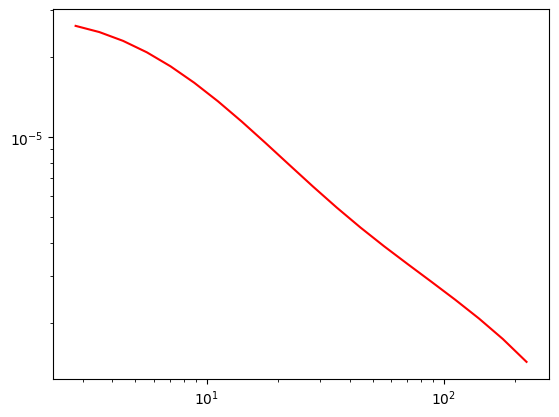

In [ ]:
 xim22 = [6.258458e-06, 6.193968e-06, 6.019024e-06, 5.729989e-06, 5.334857e-06, 4.852595e-06, 4.312537e-06, 3.748140e-06, 3.192927e-06, 2.675312e-06, 2.214770e-06, 1.821465e-06, 1.496652e-06, 1.234992e-06, 1.027523e-06, 8.628937e-07, 7.305482e-07, 6.214072e-07,5.286000e-07, 4.471312e-07]
 xim24 = [1.139527e-05, 1.107851e-05, 1.055553e-05, 9.840036e-06, 8.967113e-06, 7.987309e-06, 6.962054e-06, 5.950542e-06, 5.003677e-06, 4.158047e-06, 3.432410e-06, 2.830580e-06, 2.343817e-06, 1.955884e-06, 1.647754e-06, 1.398965e-06, 1.192771e-06, 1.016904e-06, 8.619597e-07, 7.217918e-07]
 xim44 = [ 2.612492e-05,2.476210e-05,2.294708e-05, 2.078780e-05, 1.841365e-05, 1.597199e-05, 1.360438e-05, 1.142098e-05, 9.494702e-06, 7.860294e-06, 6.514940e-06, 5.432598e-06, 4.571236e-06, 3.884298e-06, 3.326368e-06, 2.855043e-06,2.445303e-06, 2.078947e-06, 1.743171e-06, 1.429837e-06]
 xip24 = [3.886726e-05, 3.205854e-05, 2.624989e-05, 2.141010e-05, 1.745755e-05, 1.427306e-05, 1.172219e-05, 9.669851e-06, 7.996892e-06, 6.607797e-06, 5.431386e-06, 4.420275e-06, 3.544711e-06, 2.788165e-06, 2.142548e-06, 1.601635e-06, 1.159350e-06, 8.089511e-07, 5.422480e-07, 3.462798e-07]
 xip22= [2.480622e-05, 2.060116e-05, 1.692978e-05, 1.380783e-05, 1.121805e-05, 9.113242e-06, 7.426989e-06, 6.082861e-06, 5.006334e-06, 4.132262e-06, 3.408371e-06, 2.796805e-06, 2.271982e-06, 1.818250e-06, 1.427214e-06, 1.093884e-06, 8.151043e-07, 5.876010e-07, 4.081044e-07, 2.717908e-07]
plt.loglog(theta, xim44, 'r-',label=r'$\xi_{-}^{44}$')
xip44 = [7.406066e-05,6.081347e-05,4.982316e-05,4.086360e-05, 3.363594e-05, 2.781079e-05, 2.308249e-05, 1.918283e-05, 1.590231e-05, 1.309214e-05, 1.065263e-05, 8.526602e-06, 6.682374e-06, 5.106314e-06, 3.790968e-06, 2.720138e-06,1.877293e-06,1.242337e-06,7.869414e-07,4.689997e-07]


In [ ]:
xi_pia_22 = [5.939075e-05, 4.831529e-05, 3.959197e-05, 3.279262e-05, 2.745542e-05, 2.315522e-05, 1.957172e-05, 1.648850e-05, 1.376096e-05, 1.130667e-05, 9.103296e-06, 7.145950e-06, 5.440661e-06, 3.994896e-06, 2.810228e-06, 1.878184e-06, 1.181472e-06, 6.885433e-07, 3.693345e-07, 1.883792e-07]
xi_pia_44 = [5.428005e-05, 4.480230e-05, 3.683721e-05, 3.025786e-05, 2.488021e-05, 2.050256e-05, 1.692902e-05, 1.398086e-05, 1.151156e-05, 9.413309e-06, 7.612758e-06, 6.063243e-06, 4.736331e-06, 3.614966e-06, 2.685147e-06, 1.934074e-06, 1.348015e-06, 9.077288e-07, 5.656179e-07, 3.349492e-07]

xi_mia_22 = [2.612656e-05, 2.430393e-05, 2.197153e-05, 1.929697e-05, 1.649258e-05, 1.377135e-05, 1.131450e-05, 9.223056e-06, 7.517011e-06, 6.176331e-06, 5.152584e-06, 4.374820e-06, 3.775672e-06, 3.295398e-06, 2.889437e-06, 2.525411e-06, 2.184300e-06, 1.855566e-06, 1.543097e-06, 1.246678e-06]
xi_mia_44 = [ 1.847052e-05, 1.741554e-05, 1.612896e-05, 1.465262e-05, 1.304990e-05, 1.140521e-05, 9.801300e-06, 8.305502e-06, 6.965558e-06, 5.810107e-06, 4.842439e-06, 4.049521e-06, 3.406684e-06, 2.884527e-06, 2.454137e-06, 2.091361e-06, 1.777958e-06, 1.497478e-06, 1.235667e-06, 1.021635e-06]

In [ ]:
xi_pia_24 =[2.880519e-05 ,2.299062e-05, 1.853823e-05, 1.520387e-05, 1.270226e-05, 1.076971e-05, 9.206511e-06, 7.858845e-06, 6.640929e-06, 5.512128e-06, 4.462264e-06, 3.501290e-06, 2.645278e-06, 1.909394e-06, 1.302337e-06, 8.248091e-07, 4.910946e-07, 3.071046e-07, 1.740140e-07, 9.490877e-08]
xi_mia_24 = [ 1.411928e-05, 1.315394e-05, 1.188746e-05, 1.040119e-05, 8.812408e-06, 7.254746e-06, 5.842778e-06, 4.639253e-06, 3.675365e-06, 2.942559e-06, 2.406997e-06, 2.025477e-06, 1.752437e-06, 1.547001e-06, 1.378109e-06, 1.224542e-06, 1.074722e-06, 9.239338e-07, 7.738678e-07, 6.263291e-07]

### Task 5
Calculate $\xi_\pm^{ij}(\theta)$ and compare to the DES-Y3 measurements plotted above.

$$
\xi_{\pm}^{ij}(\theta) = \sum_\ell\frac{2\ell+1}{2\pi\ell^2(\ell+1)^2}[G_{\ell,2}^+(\cos\theta)\pm G_{\ell,2}^-(\cos\theta)]\times C^{ij}_{EE}(\ell)
$$
$$
G^{+}_{(l,m)}(x)=-(\frac{l-m^2}{1-x^2}+0.5l(l-1))P^m_l(x)+(l+m)\frac{x}{1-x^2}P^m_{l-1}(x)
$$
$$
G^{-}_{(l,m)}(x)=m((l-1)\frac{x}{1-x^2}P^m_l(x)-(l+m)\frac{1}{1-x^2}P^m_{l-1}(x))
$$
_If the computations in this step take more than a few seconds, think again about how to structure your code._

Text(0, 0.5, '$\\sqrt{\\theta}\\xi_{-}$')

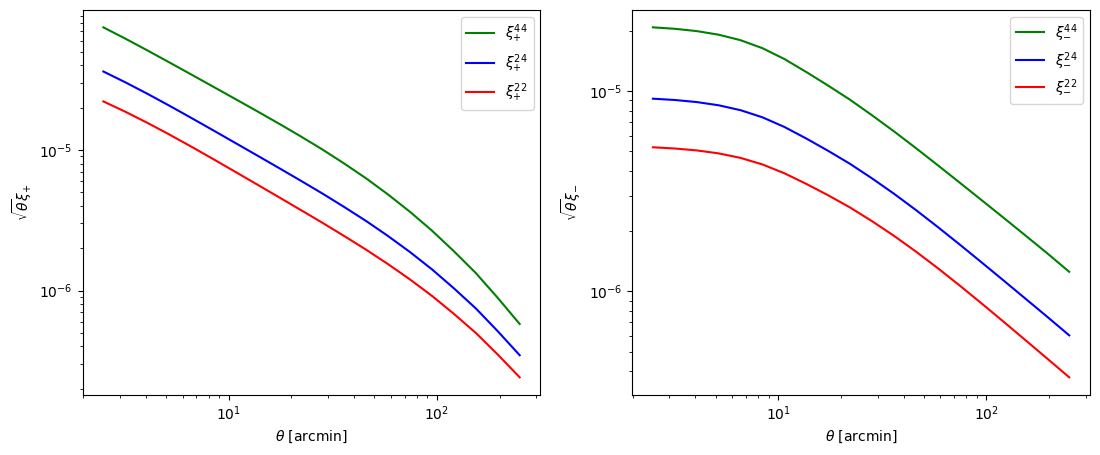

In [ ]:
def xi(theta, ell, z_data, chi_data, hubble_data, pm , bins, b,t): # xi function
  sum = 0
  theta = theta
  for i in range(len(ell)):
    l = (ell[i])
    const = (2*l+1)/(2*np.pi*l**2 * (l+1)**2)
    if (bins == "24"):
      c_kk = c_24[i]
    if (bins == "22"):
      c_kk = c_22[i]
    if (bins == "44"):
      c_kk = c_44[i]
    # G_l functions
    G_p = 1 * ((l-4)/(1 - np.cos(theta) ** 2) + 0.5 * l * (l-1)) * lpmv(2, l, np.cos(theta)) + (l+2) * np.cos(theta)/(1-np.cos(theta)**2) * lpmv(2, l-1 , np.cos(theta))
    G_m = 2 * ((l-1) * np.cos(theta)/(1- (np.cos(theta) ** 2)) * lpmv(2, l, np.cos(theta)) - (l+2)/(1-np.cos(theta)**2) * lpmv(2, l-1, np.cos(theta)))
    if (pm == "p"):
      sum += const * c_kk * (G_p + G_m)
    if (pm == "m"):
      sum += const * c_kk * (G_p - G_m)
  return sum/6

N_th = 20
theta_bin = np.exp(np.linspace(np.log(2.5),np.log(250),N_th))
theta_bins = np.exp(np.linspace(np.log(300),np.log(2000),N_th))

xi_p_24_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , "24",1,30) for theta in theta_bin]
xi_p_22_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , "22",1,30) for theta in theta_bin]
xi_p_44_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , "44",1,30) for theta in theta_bin]

xi_m_24_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , "24",10,350) for theta in theta_bin]
xi_m_22_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , "22",10,350) for theta in theta_bin]
xi_m_44_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , "44",10,350) for theta in theta_bin]

plt.figure(figsize=(13,5))
# xi_+
plt.subplot(1,2,1)
plt.loglog(theta_bin, xi_p_44_data, 'g-',label=r'$\xi_{+}^{44}$')
plt.loglog(theta_bin, xi_p_24_data, 'b-',label=r'$\xi_{+}^{24}$')
plt.loglog(theta_bin, xi_p_22_data, 'r-',label=r'$\xi_{+}^{22}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{+}$')
# xi_-
plt.subplot(1,2,2)
plt.loglog(theta_bin, xi_m_44_data, 'g-',label=r'$\xi_{-}^{44}$')
plt.loglog(theta_bin, xi_m_24_data, 'b-',label=r'$\xi_{-}^{24}$')
plt.loglog(theta_bin, xi_m_22_data, 'r-',label=r'$\xi_{-}^{22}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{-}$')

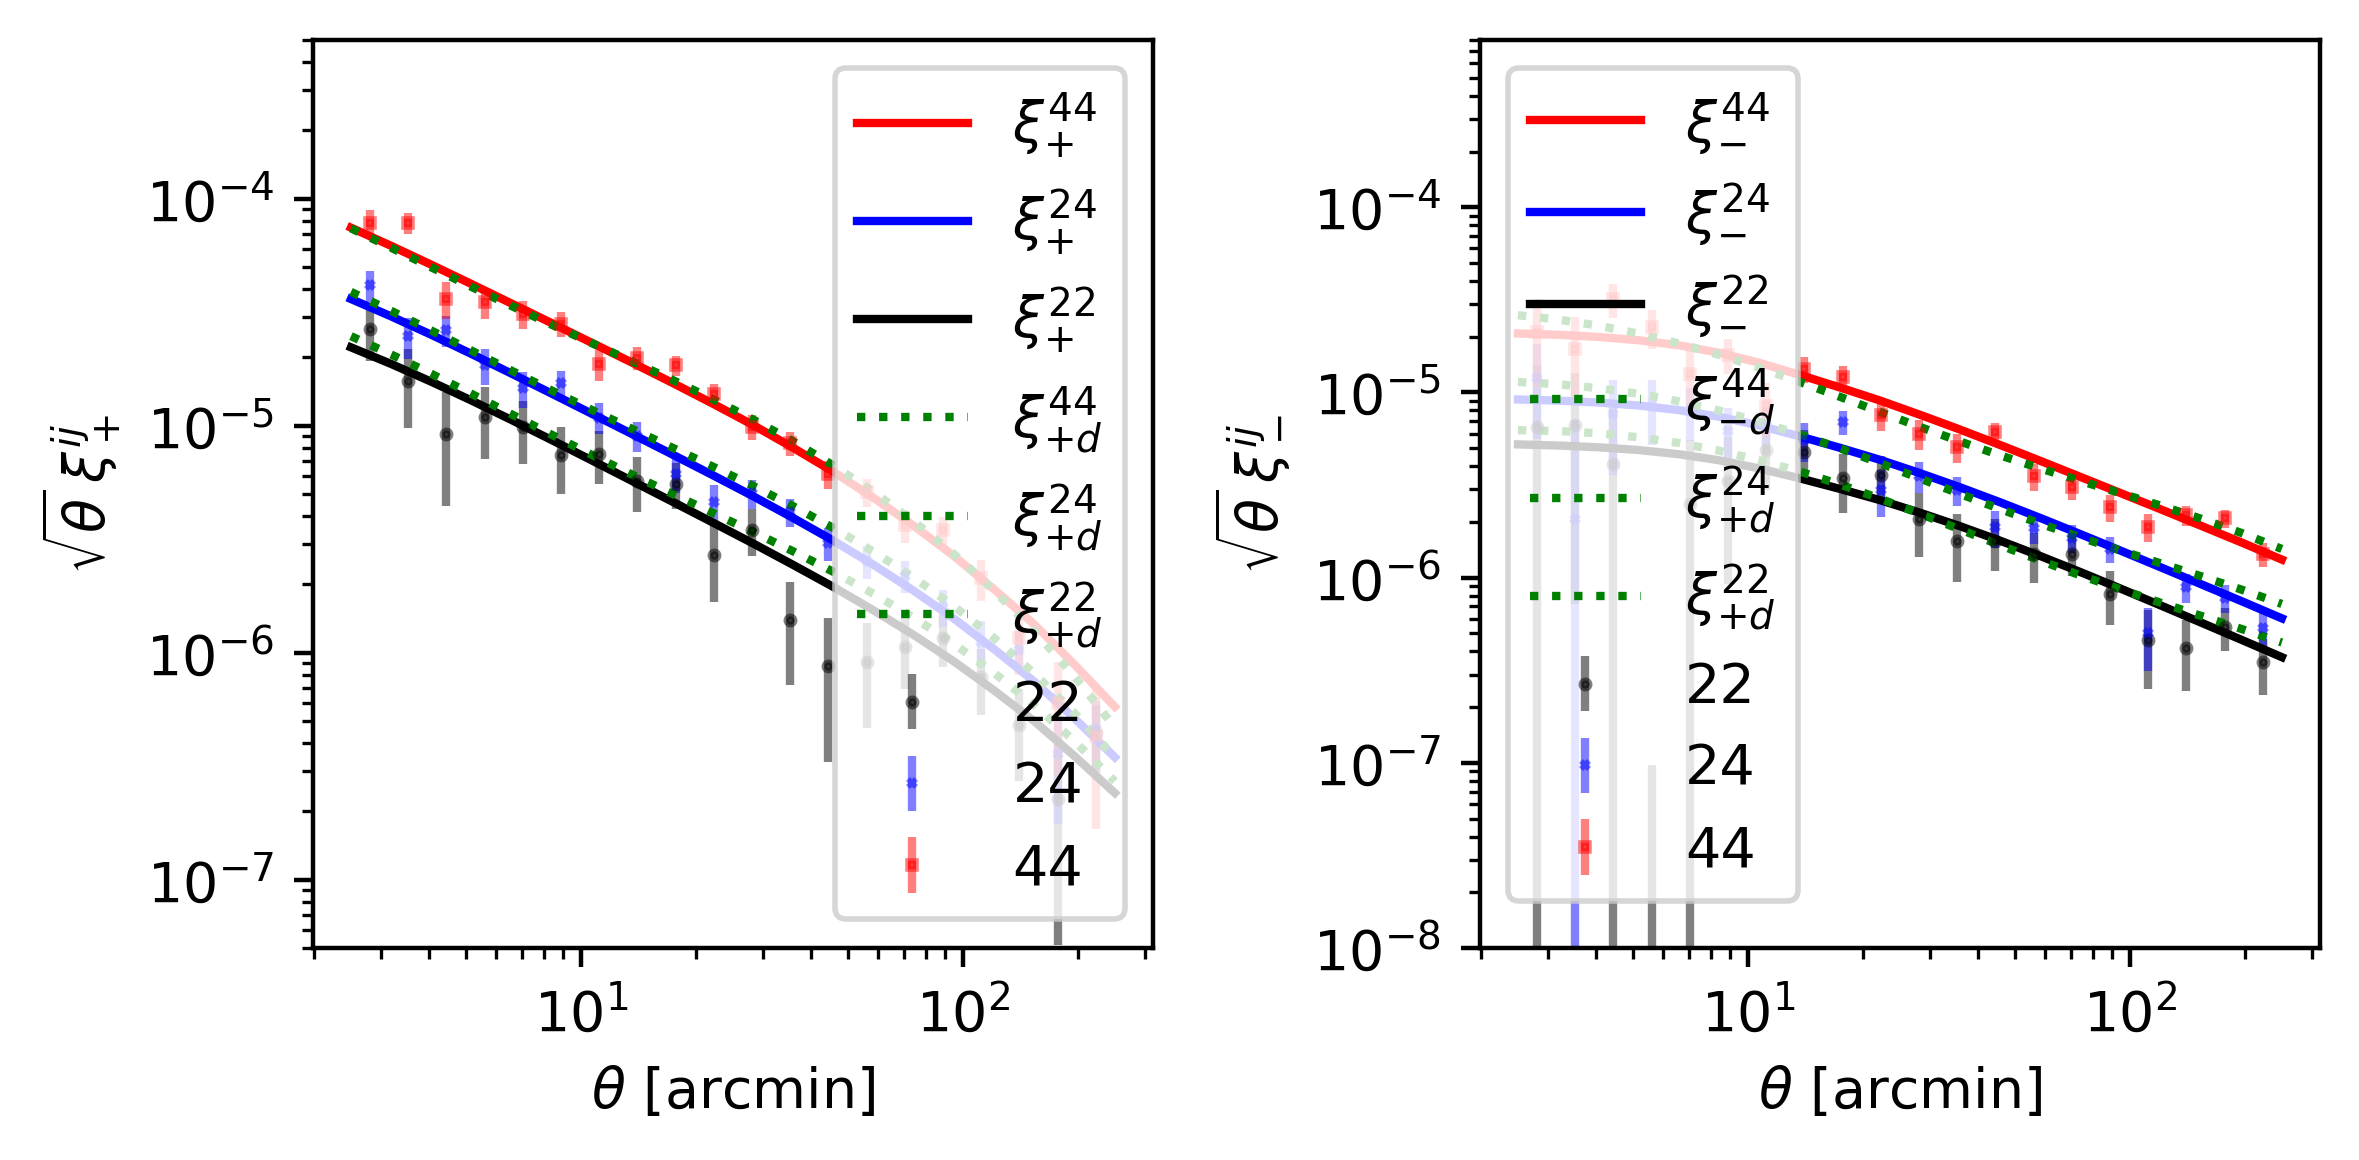

In [ ]:
#parameters describing the angular bining
N_theta_bins = 20
theta_min_arcmin = 2.5
theta_max_arcmin = 250.0
theta_edges= np.logspace(np.log10(2.5),np.log10(250),num=21)

#represent bin at geometric mean of bin edges
theta =np.sqrt(theta_edges[:-1]*theta_edges[1:])
plt.figure(figsize=(6,3), dpi=400)
fs = 18
plt.subplot(1,2,1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\,\xi_+^{ij}$')
plt.ylim(5.e-8,5.e-4)
##xi_+^{22}
ind = np.arange(80,100)
plt.errorbar(theta,d[ind],yerr=sigma[ind]*np.sqrt(1), marker='o', color='k',linestyle = '',markersize = 1.5,alpha = 0.5,label = "22")
#xi_+^{24}
ind = np.arange(120,140)
plt.errorbar(theta,d[ind]*np.sqrt(1),yerr=sigma[ind]*np.sqrt(1), marker='x', color='b',linestyle = '',markersize = 1.5,alpha = 0.5, label = "24")
#xi_+^{44}
ind = np.arange(180,200)
plt.errorbar(theta, d[ind]*np.sqrt(1),yerr=sigma[ind]*np.sqrt(1), marker='s', color='r',linestyle = '',markersize = 1.5,alpha = 0.5, label = "44")

plt.loglog(theta_bin, xi_p_44_data, 'r-',label=r'$\xi_{+}^{44}$')
plt.loglog(theta_bin, xi_p_24_data, 'b-',label=r'$\xi_{+}^{24}$')
plt.loglog(theta_bin, xi_p_22_data, 'k-',label=r'$\xi_{+}^{22}$')
# correct data
plt.loglog(theta_bin, xip44, 'g:',label=r'$\xi_{+d}^{44}$')
plt.loglog(theta_bin, xip24, 'g:',label=r'$\xi_{+d}^{24}$')
plt.loglog(theta_bin, xip22, 'g:',label=r'$\xi_{+d}^{22}$')
plt.legend()

plt.subplot(1,2,2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\,\xi_-^{ij}$')
plt.ylim(1.e-8,8.e-4)
##xi_-^{22}
ind = np.arange(280,300)
plt.errorbar(theta,d[ind],yerr=sigma[ind], marker='o', color='k',linestyle = '',markersize = 1.5,alpha = 0.5,label = "22")
#xi_-^{24}
ind = np.arange(320,340)
plt.errorbar(theta,d[ind],yerr=sigma[ind], marker='x', color='b',linestyle = '',markersize = 1.5,alpha = 0.5, label = "24")
#xi_-^{44}
ind = np.arange(380,400)
plt.errorbar(theta,d[ind],yerr=sigma[ind], marker='s', color='r',linestyle = '',markersize = 1.5,alpha = 0.5, label = "44")
plt.loglog(theta_bin, xi_m_44_data, 'r-',label=r'$\xi_{-}^{44}$')
plt.loglog(theta_bin, xi_m_24_data, 'b-',label=r'$\xi_{-}^{24}$')
plt.loglog(theta_bin, xi_m_22_data, 'k-',label=r'$\xi_{-}^{22}$')

plt.loglog(theta_bin, xim44, 'g:',label=r'$\xi_{-d}^{44}$')
plt.loglog(theta_bin, xim24, 'g:',label=r'$\xi_{+d}^{24}$')
plt.loglog(theta_bin, xim22, 'g:',label=r'$\xi_{+d}^{22}$')

plt.legend()
plt.tight_layout()

Calculating $D(z)$ for NLA IA model.

$$
D(z)=\frac{5Ω_m}{2}(\frac{H_0}{H(z)})^{2/3}\frac{(1+z)^{-1}}{Ω_m^{4/7}-\Omega_{\Lambda}+(1+\Omega_m/2)(1+\Omega_{\Lambda}/70)}
$$


In [ ]:
from scipy.interpolate import interp1d
def growth_factor(z):
  inter = interp1d(cosmo.get_background()['z'], cosmo.get_background()['gr.fac. D'], kind='linear')
  return float(inter(z))
growth_list = []
for i in range(len(z)):
  growth_list.append(growth_factor(z[i]))

Text(0, 0.5, '$C_{IA}$')

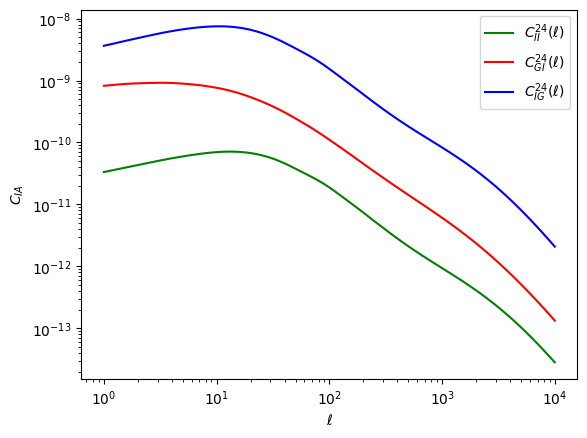

In [ ]:
# Implementing NLA intrinsic alignment.

eta = -1.7
a1 = 0.7

def A1(i):
  return (a1 * 100000 * cosmo.Omega0_m() * 3 * cosmo.Hubble(0)**2 / (8*np.pi * growth_list[i]) * (1+z[i])**eta)

def Pk_NL(k,zd):
  return(Pk_int(k,zd))

def P_GI(k,zd,i):
  if (k < 100):
    return(A1(i) * Pk_NL(k,zd))
  return 0

def P_II(k,zd,i):
  if (k < 100):
    return(A1(i) **(2) * Pk_NL(k,zd))
  return 0

def conv_spectrum_ij_NLA(l, z_data, n_i, n_j, chi_data, hubble_data, IA): # C_IA function
  dz = z_data[1]-z_data[0]
  integral = 0
  for i in range(1 , len(z_data)):
    k = (l + 0.5)/chi_data[i]
    if (IA == "II"):
      Pk = P_II(k,z[i],i)
    elif (IA == "GI"):
      Pk = P_GI(k,z[i],i)
    k_val = (l + 0.5) / chi_data[i]
    if (k_val < 100):
      integral +=  dz * n_i[i] * n_j[i] / ((chi_data[i]) ** 2 * hubble_data[i]) * Pk
  return (integral * 5)

c_II = []
for i in range(Nell):
  c_II.append(conv_spectrum_ij_NLA(ell[i], z, n[:,1], n[:,3], chi_data, hubble_data, "II"))
c_GI = []
for i in range(Nell):
  c_GI.append(conv_spectrum_ij_NLA(ell[i], z, eff_2, n[:,3], chi_data, hubble_data, "GI"))
c_IG = []
for i in range(Nell):
  c_IG.append(conv_spectrum_ij_NLA(ell[i], z, n[:,1], eff_4, chi_data, hubble_data, "GI"))

plt.loglog(ell[:-7],c_II[:-7], 'g-',label='$C_{II}^{24}(\ell)$')
plt.loglog(ell[:-7],c_GI[:-7], 'r-',label='$C_{GI}^{24}(\ell)$')
plt.loglog(ell[:-7],c_IG[:-7], 'b-',label='$C_{IG}^{24}(\ell)$')
plt.legend();
plt.xlabel('$\ell$');
plt.ylabel('$C_{IA}$')

Text(0, 0.5, '$\\sqrt{\\theta}\\xi_{-}$')

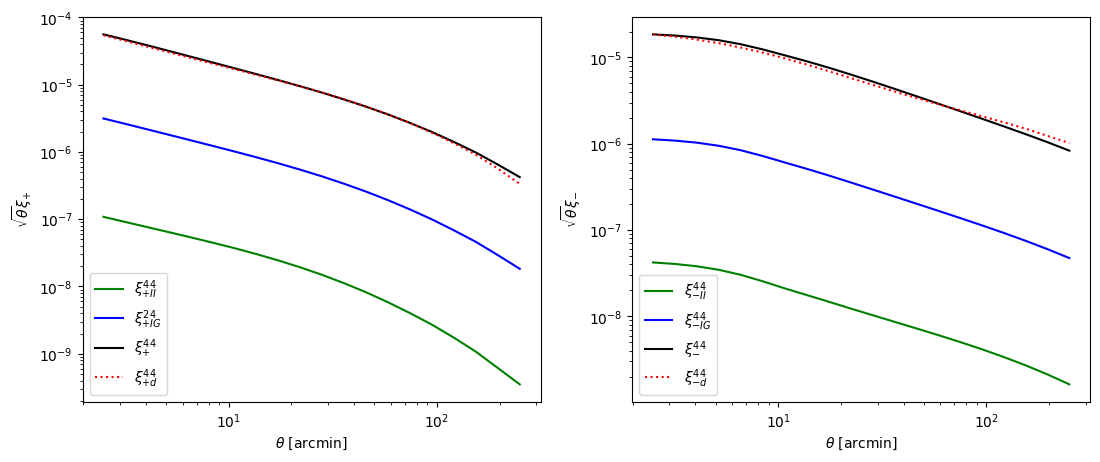

In [ ]:
# xi NLA IA

def xi(theta, ell, z_data, chi_data, hubble_data, pm, conv, b, t): # xi function
  sum = 0
  i = 0
  theta = theta
  for i in range(len(ell)):
    l = ell[i]
    const = (2*l+1)/(2*np.pi*l**2 * (l+1)**2)
    c_ij = conv[i]
    # G_l functions
    G_p = 1 * ((l-4)/(1 - np.cos(theta) ** 2) + 0.5 * l * (l-1)) * lpmv(2, l, np.cos(theta)) + (l+2) * np.cos(theta)/(1-np.cos(theta)**2) * lpmv(2, l-1 , np.cos(theta))
    G_m = 2 * ((l-1) * np.cos(theta)/(1-np.cos(theta) ** 2) * lpmv(2, l, np.cos(theta)) - (l+2)/(1-np.cos(theta)**2) * lpmv(2, l-1, np.cos(theta)))
    if (pm == "p"):
      sum += const * c_ij * (G_p + G_m)
    if (pm == "m"):
      sum += const * c_ij * (G_p - G_m)
  return sum

c_II_44 = []
for i in range(Nell):
  c_II_44.append(conv_spectrum_ij_NLA(ell[i], z, n[:,3], n[:,3], chi_data, hubble_data, "II"))
c_IG_44 = []
for i in range(Nell):
  c_IG_44.append(conv_spectrum_ij_NLA(ell[i], z, eff_4, n[:,3], chi_data, hubble_data, "GI"))
c_II_22 = []
for i in range(Nell):
  c_II_22.append(conv_spectrum_ij_NLA(ell[i], z, n[:,1], n[:,1], chi_data, hubble_data, "II"))
c_IG_22 = []
for i in range(Nell):
  c_IG_22.append(conv_spectrum_ij_NLA(ell[i], z, eff_2, n[:,1], chi_data, hubble_data, "GI"))


N_th = 20
theta_bin = np.exp(np.linspace(np.log(2.5),np.log(250),N_th))
xi_p_24II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II, 5,12) for theta in theta_bin]
xi_p_24IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG,5,12) for theta in theta_bin]
xi_p_42IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_GI,5,12) for theta in theta_bin]
xi_p_24_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II,5,12) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG,5,12) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_GI,5,12) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_24,5,12) for theta in theta_bin]

xi_p_44II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II_44,9,30) for theta in theta_bin]
xi_p_44IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG_44,9,30) for theta in theta_bin]
xi_p_44_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II_44,9,30) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG_44,9,30) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_44,9,30) for theta in theta_bin]

xi_p_22II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II_22,2,15) for theta in theta_bin]
xi_p_22IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG_22,2,15) for theta in theta_bin]
xi_p_22_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II_22,2,15) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG_22,2,15) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_22,2,15) for theta in theta_bin]

xi_m_24II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II,75,250) for theta in theta_bin]
xi_m_24IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG,75,250) for theta in theta_bin]
xi_m_42IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_GI,75,250) for theta in theta_bin]
xi_m_24_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_GI,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_24,75,250) for theta in theta_bin]

xi_m_44_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II_44,75,250) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG_44,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_44,75,250) for theta in theta_bin]
xi_m_44II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II_44,75,250) for theta in theta_bin]
xi_m_44IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG_44,75,250) for theta in theta_bin]

xi_m_22_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II_22,30,250) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG_22,30,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_22,30,250) for theta in theta_bin]
xi_m_22II_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II_22,30,250) for theta in theta_bin]
xi_m_22IG_data = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG_22,30,250) for theta in theta_bin]

plt.figure(figsize=(13,5))
# xi_+
plt.subplot(1,2,1)
plt.loglog(theta_bin, xi_p_44II_data, 'g-',label=r'$\xi_{+II}^{44}$')
plt.loglog(theta_bin, xi_p_44IG_data, 'b-',label=r'$\xi_{+IG}^{24}$')
plt.loglog(theta_bin, xi_p_44_data, 'k-',label=r'$\xi_{+}^{44}$')

plt.loglog(theta_bin, xi_iap44, 'r:',label=r'$\xi_{+d}^{44}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{+}$')
# xi_-
plt.subplot(1,2,2)
plt.loglog(theta_bin, xi_m_44II_data, 'g-',label=r'$\xi_{-II}^{44}$')
plt.loglog(theta_bin, xi_m_44IG_data, 'b-',label=r'$\xi_{-IG}^{44}$')
plt.loglog(theta_bin, xi_m_44_data, 'k-',label=r'$\xi_{-}^{44}$')

plt.loglog(theta_bin, xi_iam44, 'r:',label=r'$\xi_{-d}^{44}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{-}$')

Text(0, 0.5, '$\\sqrt{\\theta}\\xi_{-}$')

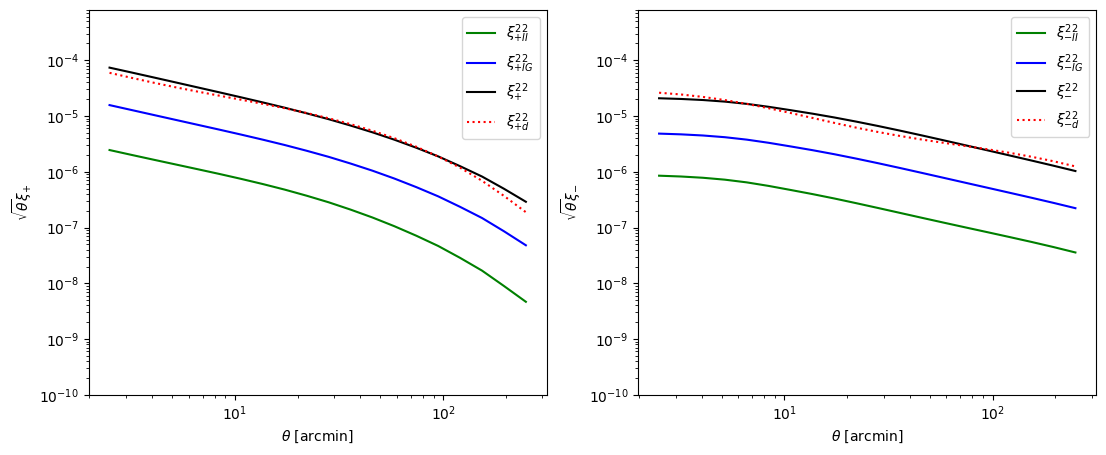

In [ ]:
plt.figure(figsize=(13,5))
# xi_+
plt.subplot(1,2,1)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin, xi_p_22II_data, 'g-',label=r'$\xi_{+II}^{22}$')
plt.loglog(theta_bin, xi_p_22IG_data, 'b-',label=r'$\xi_{+IG}^{22}$')
plt.loglog(theta_bin, xi_p_22_data, 'k-',label=r'$\xi_{+}^{22}$')

plt.loglog(theta_bin, xi_pia_22, 'r:',label=r'$\xi_{+d}^{22}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{+}$')
# xi_-
plt.subplot(1,2,2)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin, xi_m_22II_data, 'g-',label=r'$\xi_{-II}^{22}$')
plt.loglog(theta_bin, xi_m_22IG_data, 'b-',label=r'$\xi_{-IG}^{22}$')
plt.loglog(theta_bin, xi_m_22_data, 'k-',label=r'$\xi_{-}^{22}$')

plt.loglog(theta_bin, xi_mia_22, 'r:',label=r'$\xi_{-d}^{22}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{-}$')

Text(0, 0.5, '$\\sqrt{\\theta}\\xi_{-}$')

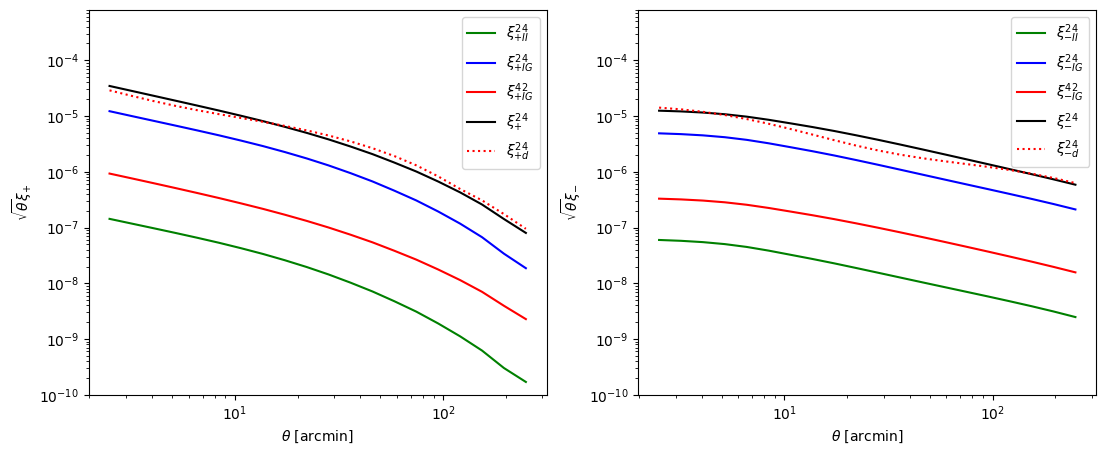

In [ ]:
plt.figure(figsize=(13,5))
# xi_+
plt.subplot(1,2,1)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin, xi_p_24II_data, 'g-',label=r'$\xi_{+II}^{24}$')
plt.loglog(theta_bin, xi_p_24IG_data, 'b-',label=r'$\xi_{+IG}^{24}$')
plt.loglog(theta_bin, xi_p_42IG_data, 'r-',label=r'$\xi_{+IG}^{42}$')
plt.loglog(theta_bin, xi_p_24_data, 'k-',label=r'$\xi_{+}^{24}$')

plt.loglog(theta_bin, xi_pia_24, 'r:',label=r'$\xi_{+d}^{24}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{+}$')
# xi_-
plt.subplot(1,2,2)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin, xi_m_24II_data, 'g-',label=r'$\xi_{-II}^{24}$')
plt.loglog(theta_bin, xi_m_24IG_data, 'b-',label=r'$\xi_{-IG}^{24}$')
plt.loglog(theta_bin, xi_m_42IG_data, 'r-',label=r'$\xi_{-IG}^{42}$')
plt.loglog(theta_bin, xi_m_24_data, 'k-',label=r'$\xi_{-}^{24}$')

plt.loglog(theta_bin, xi_mia_24, 'r:',label=r'$\xi_{-d}^{24}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{-}$')

Text(0, 0.5, '$\\sqrt{\\theta}\\xi_{-}$')

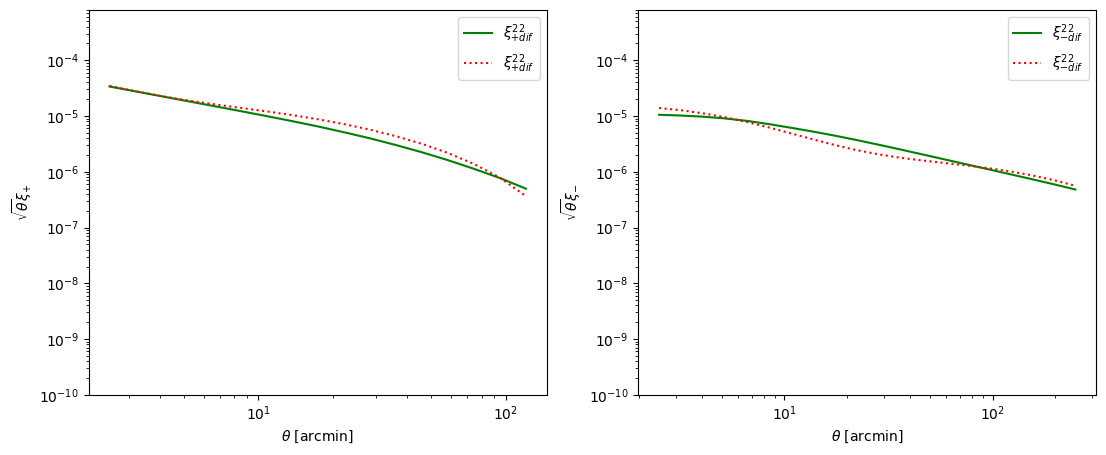

In [ ]:

xi_piadiff_22 = []
for i in range(len(theta_bin)):
  xi_piadiff_22.append(xi_pia_22[i] - xip22[i])
xi_piadiff_24 = []
for i in range(len(theta_bin)):
  xi_piadiff_24.append(xi_pia_24[i] - xip24[i])

xi_miadiff_22 = []
for i in range(len(theta_bin)):
  xi_miadiff_22.append(0.7*(xi_mia_22[i] - xim22[i]))
xi_miadiff_24 = []
for i in range(len(theta_bin)):
  xi_miadiff_24.append(xi_mia_24[i] - xim24[i])

xi_m_24_datadiff = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG,75,250) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_GI,75,250) for theta in theta_bin]

xi_m_22_datadiff = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_II_22,30,250) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "m" , c_IG_22,30,250) for theta in theta_bin]

xi_p_24_datadiff = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II,5,12) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG,5,12) +
                 xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_GI,5,12) for theta in theta_bin]

xi_p_22_datadiff = [ xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_II_22,2,15) +
                2 * xi(np.deg2rad(theta), ell, z, chi_data, hubble_data, "p" , c_IG_22,2,15) for theta in theta_bin]

plt.figure(figsize=(13,5))
# xi_+
plt.subplot(1,2,1)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin[:-3], xi_p_22_datadiff[:-3], 'g-',label=r'$\xi_{+dif}^{22}$')

plt.loglog(theta_bin[:-3], xi_piadiff_22[:-3], 'r:',label=r'$\xi_{+dif}^{22}$')

plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{+}$')
# xi_-
plt.subplot(1,2,2)
plt.ylim(1.e-10,8.e-4)
plt.loglog(theta_bin, xi_m_22_datadiff, 'g-',label=r'$\xi_{-dif}^{22}$')

plt.loglog(theta_bin, xi_miadiff_22, 'r:',label=r'$\xi_{-dif}^{22}$')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\sqrt{\theta}\xi_{-}$')